In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.formula.api as smf

## Data Handling

## Heterogenous Autoregressive (HAR)

In [156]:
df = pd.read_excel(r'/Users/murphyk/Volatility Modeling/SPX.xlsx')

In [159]:
df['LogRet'] = np.log(df['Close']) - np.log(df['Close'].shift(1))

df['RV'] = (np.log(df['High'] / df['Low'])**2 / (4 * np.log(2))) * 10000

df['RV_d'] = df['RV'].shift(1)
df['RV_w'] = df['RV'].rolling(5).mean().shift(1)
df['RV_m'] = df['RV'].rolling(21).mean().shift(1)

fit = smf.ols(data=df, formula='RV ~ RV_d + RV_w + RV_m').fit()


In [160]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     RV   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     1398.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        00:55:22   Log-Likelihood:                -3251.2
No. Observations:                2498   AIC:                             6510.
Df Residuals:                    2494   BIC:                             6534.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0947      0.021      4.477      0.0

In [141]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

class HARModel:
    def __init__(self, data, estimator='close-to-close'):
        self.df = self.calculate_RV(data, estimator)
        self.model = self.fit_model()

    def calculate_RV(self, data, estimator):
        df = data.copy()
        df.index = pd.to_datetime(df.index)  # Ensure the index is a datetime index
        df['LogRet'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
        if estimator == 'close-to-close':
            df['RV'] = np.sqrt(df['LogRet']**2) * 100
        elif estimator == 'parkinson':
            df['RV'] = (np.log(df['High'] / df['Low'])**2 / (4 * np.log(2))) * 10000

        df['RV_d'] = df['RV'].shift(1)
        df['RV_w'] = df['RV'].rolling(5).mean().shift(1)
        df['RV_m'] = df['RV'].rolling(22).mean().shift(1)

        return df.dropna()

    def fit_model(self):
        fit = smf.ols(data=self.df, formula='RV ~ RV_d + RV_w + RV_m').fit()
        return fit

    @property
    def fittedvalues(self):
        return self.model.fittedvalues

    def plot(self):
        plt.figure(figsize=(1.618*5, 5))

        plt.subplot(2, 1, 1)
        plt.plot(self.df.index, self.df['Close'], label='Close Price')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(self.df.index, self.df['RV'], label='Realized Volatility')
        plt.plot(self.df.index, self.fittedvalues, label='Fitted RV', linestyle='--')
        plt.legend()

        plt.show()

    def predict(self, steps=1):
        last_row = self.df.iloc[-1].copy()
        predictions = []

        for _ in range(steps):
            new_data = {
                'RV_d': last_row['RV'],
                'RV_w': last_row['RV_w'],
                'RV_m': last_row['RV_m']
            }
            prediction = self.model.predict(pd.DataFrame([new_data]))
            predictions.append(prediction.values[0])

            # Update last_row for next prediction step
            last_row['RV'] = prediction.values[0]
            last_row['RV_d'] = last_row['RV']
            last_row['RV_w'] = (last_row['RV_w'] * 4 + last_row['RV']) / 5
            last_row['RV_m'] = (last_row['RV_m'] * 21 + last_row['RV']) / 22

        return np.array(predictions)

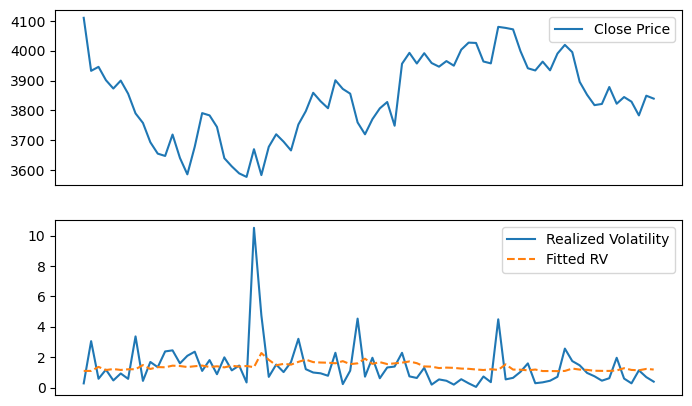

In [144]:
data = pd.read_excel(r'/Users/murphyk/Volatility Modeling/SPX.xlsx')
#data.set_index('Date',inplace=True)
data=data[-100:]
har_model = HARModel(data, estimator='parkinson')
har_model.plot()

In [140]:
har_model.predict(5)

array([1.15863527, 1.2251778 , 1.23119509, 1.23242606, 1.23358624])

In [ ]:
brig